In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
#export
from export.nb_00 import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch, re
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, Tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp
from dataclasses import field
from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from typing import Tuple, Hashable, Mapping, Dict
from numbers import Number

import mimetypes, abc, functools
from abc import abstractmethod, abstractproperty

D:\narain\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if sys.path[0] == '':


In [3]:
data_path.ls()

(#5) [Path('d:/git/dl/data/cifar.zip'),Path('d:/git/dl/data/cifar10'),Path('d:/git/dl/data/imagenette2-160'),Path('d:/git/dl/data/imagewoof2-160'),Path('d:/git/dl/data/mnist.pkl.gz')]

In [5]:
cifar_path=data_path/'cifar10'
cifar_train=cifar_path/'train'
cifar_path.ls(), cifar_train.ls()

((#2) [Path('d:/git/dl/data/cifar10/test'),Path('d:/git/dl/data/cifar10/train')],
 (#10) [Path('d:/git/dl/data/cifar10/train/airplane'),Path('d:/git/dl/data/cifar10/train/automobile'),Path('d:/git/dl/data/cifar10/train/bird'),Path('d:/git/dl/data/cifar10/train/cat'),Path('d:/git/dl/data/cifar10/train/deer'),Path('d:/git/dl/data/cifar10/train/dog'),Path('d:/git/dl/data/cifar10/train/frog'),Path('d:/git/dl/data/cifar10/train/horse'),Path('d:/git/dl/data/cifar10/train/ship'),Path('d:/git/dl/data/cifar10/train/truck')])

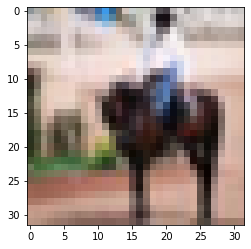

In [6]:
dog_path=cifar_train.ls()[7]
img_dog=dog_path.ls()[1]
dog_img=PIL.Image.open(img_dog)
plt.imshow(dog_img)

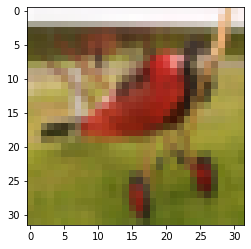

In [7]:
tench_path=cifar_train.ls()[0]
img_tench=tench_path.ls()[2]
tench_img=PIL.Image.open(img_tench)
plt.imshow(tench_img)

In [8]:
#export 

def img2np(image: Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style"
    res = image.cpu().permute(1,2,0).numpy()
    return res[...,0] if res.shape[2]==1 else res

def show_image(img:Tensor, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, 
               title:Optional[str]=None, cmap:str='binary', alpha:Optional[float]=None)->plt.Axes:
    "Plot tensor `img` using matplotlib axis `ax`.  `figsize`,`axis`,`title`,`cmap` and `alpha` pass to `ax.imshow`"
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img2np(img), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    if title: ax.set_title(title)
    return ax

In [9]:
class Image():
    def __init__(self, px): self.px = px
    def show(self, ax=None, **kwargs): return show_image(self.px, ax=ax, **kwargs)
    @property
    def data(self): return self.px

In [10]:
#export
FilePathList= Collection[Union[np.ndarray, L]]
TensorImage= Tensor
NPImage=np.ndarray

def find_classes(folder: Path)-> FilePathList:
    'return class subdirectories in imagenet style train folder'
    classes=L([d for d in folder.iterdir()
            if d.is_dir() and not d.name.startswith('.')])
    assert(len(classes)>0)
    return L(sorted(classes, key=lambda d:d.name))
#     return classes.sort(key=Lambda d:d.name)

image_extensions=set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

def get_image_files(c:Path, check_ext:bool=True)->FilePathList:
    'return list of files in c that are images, `check_ext` will filter to image extensions'
    return L([o for o in (c.iterdir())
           if not (o.name.startswith('.')) or o.is_dir()
           or (check_ext and o.suffix not in image_extensions)])

def pil2tensor(image:NPImage)->TensorImage:
    'convert PIL style `image` array to torch style image tensor `get_image_files`'
    arr=torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr=arr.view(image.size[1], image.size[0], -1)
    return arr.permute(2,0,1)

PathOrStr=Union[Path, str]
def open_image(fn: PathOrStr):
    'return `image` object created from image in file `fn`'
    x=PIL.Image.open(fn).convert('RGB')
    return Image(pil2tensor(x).float().div_(255))

In [11]:
get_image_files(dog_path)

(#5000) [Path('d:/git/dl/data/cifar10/train/horse/0001.png'),Path('d:/git/dl/data/cifar10/train/horse/0002.png'),Path('d:/git/dl/data/cifar10/train/horse/0003.png'),Path('d:/git/dl/data/cifar10/train/horse/0004.png'),Path('d:/git/dl/data/cifar10/train/horse/0005.png'),Path('d:/git/dl/data/cifar10/train/horse/0006.png'),Path('d:/git/dl/data/cifar10/train/horse/0007.png'),Path('d:/git/dl/data/cifar10/train/horse/0008.png'),Path('d:/git/dl/data/cifar10/train/horse/0009.png'),Path('d:/git/dl/data/cifar10/train/horse/0010.png')...]

In [12]:
find_classes(cifar_train)

(#10) [Path('d:/git/dl/data/cifar10/train/airplane'),Path('d:/git/dl/data/cifar10/train/automobile'),Path('d:/git/dl/data/cifar10/train/bird'),Path('d:/git/dl/data/cifar10/train/cat'),Path('d:/git/dl/data/cifar10/train/deer'),Path('d:/git/dl/data/cifar10/train/dog'),Path('d:/git/dl/data/cifar10/train/frog'),Path('d:/git/dl/data/cifar10/train/horse'),Path('d:/git/dl/data/cifar10/train/ship'),Path('d:/git/dl/data/cifar10/train/truck')]

In [13]:
isinstance(L, Collection)

False

In [14]:
#export
NPArrayableList= Collection[Union[np.ndarray, L]]
NPArrayMask=np.ndarray
SplitArrayList=L([Tuple[np.ndarray, np.ndarray]])

def arrays_split(maskLNPArrayMask, *arrs:NPArrayableList)->SplitArrayList:
    'Given `arrs` is [a,b,...] and `mask` index - return [(a[mask], a[-mask]), (b[mask],b[~mask]),...]'
    mask=array(mask)
    return list(zip(*[(a[mask],a[~mask]) for a in map(np.array, arrs)]))

def random_split(valid_pct:float, *arrs:NPArrayableList)->SplitArrayList:
    'randomly `array_split` with `valid_pct` ratio good for creating validation set'
    is_train=np.random.uniform(size=(len(arrs[0]),))>valid_pct
    return arrays_split(is_train, *arrs)

class DatasetBase(Dataset):
    'Base class for all datasets'
    def __len__(self): return len(self.x)
    @property
    def c(self):
        'number of variable expressed by `y` variable'
        return self.y.shape[-1] if len(self.y.shape)>1 else 1
    def __repr__(self): return f'{type(self).__name__} if len {len(self)}'
    
class LabelDataset(DatasetBase):
    'Base class for datasets for classification'
    @property
    def c(self):
        'number of classes expressed by dataset y variable'
        return len(self.classes)

In [15]:
ImgLabel=str
ImgLabels= Collection[ImgLabel]
Classes= Collection[Any]

class ImageDataset(LabelDataset):
    'Dataset for folders of images in style {folder}/{class}/{images}'
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Classes]=None):
        self.classes=ifnone(classes, L(set(labels)))
        self.class2idx= {v:k for k,v in enumerate(self.classes)}
        self.x=np.array(fns)
        self.y=np.array([self.class2idx[o] for o in labels], dtype=np.int64)
        
    def __getitem__(self, i): return open_image(self.x[i]), self.y[i]
    
    @staticmethod
    def _folder_files(folder:Path, label:ImgLabel, check_ext=True)->Tuple[FilePathList, ImgLabels]:
        'from `folder` return image files and labels the labels are all `label`, `check_ext` means only image files'
        fnames=get_image_files(folder, check_ext=check_ext)
        return fnames, [label]*len(fnames)
    
    @classmethod
    def from_single_folder(cls, folder:PathOrStr, classes:Classes, check_ext=True):
        "Typically used for test set. label all images in `folder` with `classes[0]`"
        fns,labels = cls._folder_files(folder, classes[0], check_ext=check_ext)
        return cls(fns, labels, classes=classes)
    
    @classmethod
    def from_folder(cls, folder:Path, classes:Optional[Classes]=None,
                   valid_pct:float=0.,check_ext:bool=True)->Union['ImageDataset', List['ImageDataset']]:
        'Dataset of `classes` labeled images in `folder` Optional` `valid_pct` split validation set'
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns, labels=[],[]
        for cl in classes:
            f,l =cls._folder_files(folder/cl,cl,check_ext=check_ext)
            fns+=f;labels+=l
            
        if valid_pct==0:
            return cls(fns, labels, classes=classes)
        return [cls(*a, classes=classes) for a in random_split(valid_pct, fns, labels)]

In [16]:
train_ds=ImageDataset.from_folder(cifar_train); train_ds

ImageDataset if len 50000

In [17]:
def logit(x:Tensor)->Tensor: return -(1/x-1).log()
def logit_(x:Tensor)->Tensor: return (x.reciprocal_().sub(1)).log_().neg_()

In [18]:
def contrast(x:Tensor, scale:Tensor)->Tensor: return x.mul_(scale)

In [19]:
#export
FlowField = Tensor
LogitTensorImage = TensorImage
AffineMatrix = Tensor
KWArgs = Dict[str,Any]
ArgStar = Collection[Any]
TensorImageSize = Tuple[int,int,int]

LightingFunc = Callable[[LogitTensorImage, ArgStar, KWArgs], LogitTensorImage]
PixelFunc = Callable[[TensorImage, ArgStar, KWArgs], TensorImage]
CoordFunc = Callable[[FlowField, TensorImageSize, ArgStar, KWArgs], LogitTensorImage]
AffineFunc = Callable[[KWArgs], AffineMatrix]


class ItemBase():
    "All transformable dataset items use this type"
    @property
    @abstractmethod
    def device(self): pass
    @property
    @abstractmethod
    def data(self): pass

class ImageBase(ItemBase):
    "Img based `Dataset` items derive from this. Subclass to handle lighting, pixel, etc"
    def lighting(self, func:LightingFunc, *args, **kwargs)->'ImageBase': return self
    def pixel(self, func:PixelFunc, *args, **kwargs)->'ImageBase': return self
    def coord(self, func:CoordFunc, *args, **kwargs)->'ImageBase': return self
    def affine(self, func:AffineFunc, *args, **kwargs)->'ImageBase': return self

    def set_sample(self, **kwargs)->'ImageBase':
        "Set parameters that control how we `grid_sample` the image after transforms are applied"
        self.sample_kwargs = kwargs
        return self
    
    def clone(self)->'ImageBase': 
        "Clones this item and its `data`"
        return self.__class__(self.data.clone())

In [20]:
#export
class Image(ImageBase):
    "Supports appying transforms to image data"
    def __init__(self, px)->'Image':
        "create from raw tensor image data `px`"
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    @property
    def shape(self)->Tuple[int,int,int]: 
        "Returns (ch, h, w) for this image"
        return self._px.shape
    @property
    def size(self)->Tuple[int,int]: 
        "Returns (h, w) for this image"
        return self.shape[-2:]
    @property
    def device(self)->torch.device: return self._px.device
    
    def __repr__(self): return f'{self.__class__.__name__} ({self.shape})'

    def refresh(self)->None:
        "Applies any logit or affine transfers that have been "
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_()
            self._logit_px = None
        if self._affine_mat is not None or self._flow is not None:
            self._px = grid_sample(self._px, self.flow, **self.sample_kwargs)
            self.sample_kwargs = {}
            self._flow = None
        return self

    @property
    def px(self)->TensorImage:
        "Get the tensor pixel buffer"
        self.refresh()
        return self._px
    @px.setter
    def px(self,v:TensorImage)->None: 
        "Set the pixel buffer to `v`"
        self._px=v

    @property
    def flow(self)->FlowField:
        "Access the flow-field grid after applying queued affine transforms"
        if self._flow is None:
            self._flow = affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = affine_mult(self._flow,self._affine_mat)
            self._affine_mat = None
        return self._flow
    
    @flow.setter
    def flow(self,v:FlowField): self._flow=v

    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image':
        "Equivalent to `image = sigmoid(func(logit(image)))`"
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self

    def pixel(self, func:PixelFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.px = func(image.px)`"
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func:CoordFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.flow = func(image.flow, image.size)`"        
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        return self

    def affine(self, func:AffineFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.affine_mat = image.affine_mat @ func()`"        
        m = tensor(func(*args, **kwargs)).to(self.device)
        self.affine_mat = self.affine_mat @ m
        return self

    def resize(self, size:Union[int,TensorImageSize])->'Image':
        "Resize the image to `size`, size can be a single int"
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = affine_grid(size)
        return self

    @property
    def affine_mat(self)->AffineMatrix:
        "Get the affine matrix that will be applied by `refresh`"
        if self._affine_mat is None:
            self._affine_mat = torch.eye(3).to(self.device)
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v)->None: self._affine_mat=v

    @property
    def logit_px(self)->LogitTensorImage:
        "Get logit(image.px)"
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v:LogitTensorImage)->None: self._logit_px=v
    
    def show(self, ax:plt.Axes=None, **kwargs:Any)->None: 
        "Plots the image into `ax`"
        show_image(self.px, ax=ax, **kwargs)
    
    @property
    def data(self)->TensorImage: 
        "Returns this images pixels as a tensor"
        return self.px

In [21]:
cifar_path.ls()

(#2) [Path('d:/git/dl/data/cifar10/test'),Path('d:/git/dl/data/cifar10/train')]

In [22]:
train_ds=ImageDataset.from_folder(cifar_train)
valid_ds=ImageDataset.from_folder(cifar_path/'test')

In [23]:
img_test=lambda: train_ds[9][0]

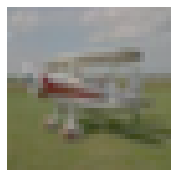

In [24]:
img=img_test()
img.logit_px=contrast(img.logit_px, 0.5)
img.show()

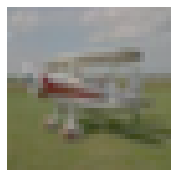

In [25]:
img_test().lighting(contrast, 0.5).show()

In [26]:
class Transform():
    _wrap=None
    def __init__(self, func): self.func=func
    def __call__(self, x, *args, **kwargs):
        if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else: return self.func(x, *args, **args)
        

class TfmLighting(Transform): _wrap='lighting'

In [27]:
@TfmLighting
def brightness(x, change): return x.add_(scipy.special.logit(change))
@TfmLighting
def contrast(x, scale): return x.mul_(scale)

In [28]:
print(inspect.getsource(is_listy))

def is_listy(x:Any)->bool: return isinstance(x, (tuple,list))



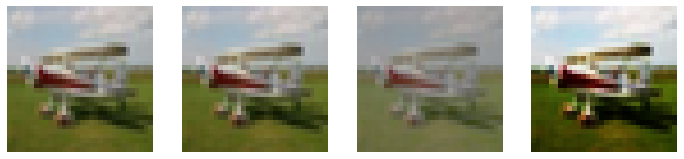

In [29]:
_,axes = plt.subplots(1,4, figsize=(12,3))

img_test().show(axes[0])
contrast(img_test(), 1.0).show(axes[1])
contrast(img_test(), 0.5).show(axes[2])
contrast(img_test(), 2.0).show(axes[3])

In [30]:
def brightness_contrast(x, scale_contrast, change_brightness):
    return brightness(contrast(x, scale=scale_contrast), change=change_brightness)

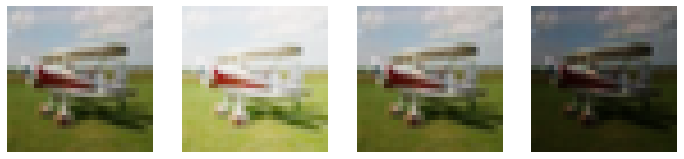

In [31]:
_,axes = plt.subplots(1,4, figsize=(12,3))

img_test().show(axes[0])
brightness(img_test(), 0.8).show(axes[1])
brightness(img_test(), 0.5).show(axes[2])
brightness(img_test(), 0.2).show(axes[3])

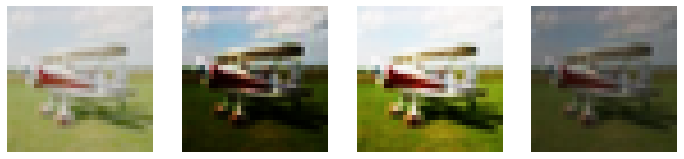

In [32]:
_,axes = plt.subplots(1,4, figsize=(12,3))

brightness_contrast(img_test(), 0.75, 0.7).show(axes[0])
brightness_contrast(img_test(), 2.0,  0.3).show(axes[1])
brightness_contrast(img_test(), 2.0,  0.7).show(axes[2])
brightness_contrast(img_test(), 0.75, 0.3).show(axes[3])

In [33]:
#export
FloatOrTensor = Union[float,Tensor]
BoolOrTensor = Union[bool,Tensor]
def uniform(low:Number, high:Number, size:List[int]=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=`low`, max=`high`"
    return random.uniform(low,high) if size is None else torch.FloatTensor(*listify(size)).uniform_(low,high)

def log_uniform(low, high, size=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=log(`low`), max=log(`high`)"
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p:float, size=None)->BoolOrTensor: 
    "Draw 1 or shape=`size` random booleans (True occuring probability p)"
    return uniform(0,1,size)<p

In [34]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

1.0195950988321643

In [35]:
#export
import inspect
from copy import copy,deepcopy

def get_default_args(func:Callable):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

ListOrItem = Union[Collection[Any],int,float,str]
OptListOrItem = Optional[ListOrItem]
def listify(p:OptListOrItem=None, q:OptListOrItem=None):
    "Makes `p` same length as `q`"
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

In [36]:
#export
class Transform():
    "Utility class for adding probability and wrapping support to transform funcs"
    _wrap=None
    order=0
    def __init__(self, func:Callable, order:Optional[int]=None)->None:
        "Create a transform for `func` and assign it an priority `order`, attach to Image class"
        if order is not None: self.order=order
        self.func=func
        functools.update_wrapper(self, self.func)
        self.func.__annotations__['return'] = Image
        self.params = copy(func.__annotations__)
        self.def_args = get_default_args(func)
        setattr(Image, func.__name__,
                lambda x, *args, **kwargs: self.calc(x, *args, **kwargs))
        
    def __call__(self, *args:Any, p:float=1., is_random:bool=True, **kwargs:Any)->Image:
        "Calc now if `args` passed; else create a transform called prob `p` if `random`"
        if args: return self.calc(*args, **kwargs)
        else: return RandTransform(self, kwargs=kwargs, is_random=is_random, p=p)
        
    def calc(self, x:Image, *args:Any, **kwargs:Any)->Image:
        "Apply this transform to image `x`, wrapping it if necessary"
        if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          return self.func(x, *args, **kwargs)

    @property
    def name(self)->str: return self.__class__.__name__
    
    def __repr__(self)->str: return f'{self.name} ({self.func.__name__})'

class TfmLighting(Transform): order,_wrap = 8,'lighting'

In [37]:
#export
@dataclass
class RandTransform():
    "Wraps `Transform` to add randomized execution"
    tfm:Transform
    kwargs:dict
    p:int=1.0
    resolved:dict = field(default_factory=dict)
    do_run:bool = True
    is_random:bool = True
    def __post_init__(self): functools.update_wrapper(self, self.tfm)
    
    def resolve(self)->None:
        "Bind any random variables needed tfm calc"
        if not self.is_random:
            self.resolved = {**self.tfm.def_args, **self.kwargs}
            return

        self.resolved = {}
        # for each param passed to tfm...
        for k,v in self.kwargs.items():
            # ...if it's annotated, call that fn...
            if k in self.tfm.params:
                rand_func = self.tfm.params[k]
                self.resolved[k] = rand_func(*listify(v))
            # ...otherwise use the value directly
            else: self.resolved[k] = v
        # use defaults for any args not filled in yet
        for k,v in self.tfm.def_args.items():
            if k not in self.resolved: self.resolved[k]=v
        # anything left over must be callable without params
        for k,v in self.tfm.params.items():
            if k not in self.resolved and k!='return': self.resolved[k]=v()

        self.do_run = rand_bool(self.p)

    @property
    def order(self)->int: return self.tfm.order

    def __call__(self, x:Image, *args, **kwargs)->Image:
        "Randomly execute our tfm on `x`"
        return self.tfm(x, *args, **{**self.resolved, **kwargs}) if self.do_run else x

In [38]:
#export
@TfmLighting
def brightness(x, change:uniform): 
    "`change` brightness of image `x`"
    return x.add_(scipy.special.logit(change))

@TfmLighting
def contrast(x, scale:log_uniform): 
    "`scale` contrast of image `x`"
    return x.mul_(scale)

In [39]:
img_test = lambda: train_ds[1][0]

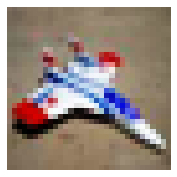

In [40]:
img_test().contrast(scale=2).show()

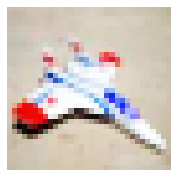

In [41]:
img_test().contrast(scale=2).brightness(0.8).show()

In [42]:
tfm = contrast(scale=(0.3,3))
tfm.resolve()
tfm,tfm.resolved,tfm.do_run

(RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.3, 3)}, p=1.0, resolved={'scale': 2.2955972752051292}, do_run=True, is_random=True),
 {'scale': 2.2955972752051292},
 True)

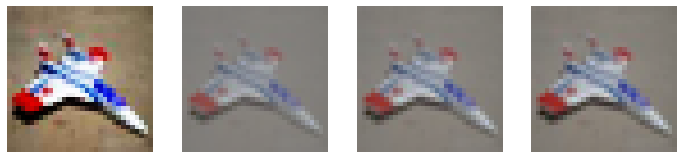

In [43]:
tfm = contrast(scale=(0.3,3))

# different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    tfm(img_test()).show(ax)

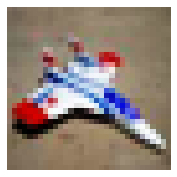

In [44]:
tfm = contrast(scale=2, is_random=False)
tfm.resolve()
tfm(img_test()).show()

## composition

In [45]:
#export
TfmList=Union[Transform, Collection[Transform]]
def resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`"
    for f in listify(tfms): f.resolve()

def apply_tfms(tfms:TfmList, x:Image, do_resolve:bool=True):
    "Apply all the `tfms` to `x`, if `do_resolve` refresh all the random args"
    if not tfms: return x
    tfms = listify(tfms)
    if do_resolve: resolve_tfms(tfms)
    x = x.clone()
    for tfm in tfms: x = tfm(x)
    return x

In [46]:
x = train_ds[1][0]

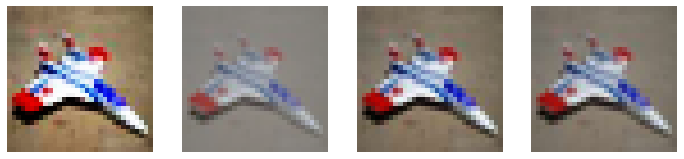

In [47]:
tfms = [contrast(scale=(0.3,3.0), p=0.9),
        brightness(change=(0.35,0.65), p=0.9)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x).show(ax)

In [48]:
apply_tfms([],img_test)

<function __main__.<lambda>()>

## DatasetTfm

In [49]:
#export 
class DatasetTfm(Dataset):
    'A `Dataset` that applies a list of transforms to every item drawn'
    def __init__(self, ds:Dataset, tfms:TfmList=None, **kwargs:Any):
        self.ds, self.tfms, self.kwargs=ds, tfms, kwargs
        
    def __len__(self)-> int: return len(self.ds)
    def __getitem__(self, idx:int)->Tuple[Image, Any]:
        'returns tfms(x), y'
        x,y=self.ds[idx]
        return apply_tfms(self.tfms, x, **self.kwargs), y
    
    def __getattr__(self, k):
        'passthrough access to wrapped dataset attributes'
        return getattr(self.ds, k)
    
import export.nb_00 
export.nb_00.DatasetTfm=DatasetTfm

In [50]:
bs=64

In [51]:
#export
ItemsList = Collection[Union[Tensor,ItemBase,'ItemsList',float,int]]
def to_data(b:ItemsList):
    "Recursively maps lists of items to their wrapped data"
    if is_listy(b): return [to_data(o) for o in b]
    return b.data if isinstance(b,ItemBase) else b

def data_collate(batch:ItemsList)->Tensor:
    "Convert `batch` items to tensor data"
    return torch.utils.data.dataloader.default_collate(to_data(batch))

@dataclass
class DeviceDataLoader():
    "DataLoader that ensures items in each batch are tensor on specified device"
    dl: DataLoader
    device: torch.device
    def __post_init__(self)->None: self.dl.collate_fn=data_collate

    def __len__(self)->int: return len(self.dl)
    def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
    def proc_batch(self,b:ItemsList)->Tensor: return to_device(b, self.device)

    def __iter__(self):
        self.gen = map(self.proc_batch, self.dl)
        return iter(self.gen)

    @classmethod
    def create(cls, *args, device=default_device, **kwargs)->'DeviceDataLoader':
        "Creates `DataLoader` and make sure its data is always on `device`"
        return cls(DataLoader(*args, **kwargs), device=device)
    
export.nb_00.DeviceDataLoader= DeviceDataLoader

In [52]:
data = DataBunch.create(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl), data.train_dl.dataset.c

(782, 79, 10)

In [53]:
#export
def show_image_batch(dl:DataLoader, classes:Collection[str], 
                     rows:Optional[int]=None, figsize:Tuple[int,int]=(12,15))->None:
    "Show a batch of images from `dl` titled according to `classes`"
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x:Collection[Image],y:int,rows:int, classes:Collection[str], figsize:Tuple[int,int]=(9,9))->None:
    "Plot images (`x[i]`) from `x` titled according to classes[y[i]]"
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

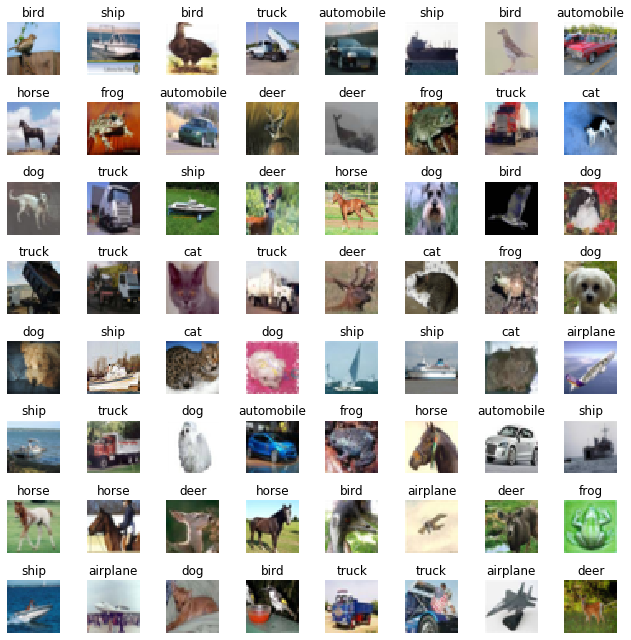

In [54]:
show_image_batch(data.train_dl, train_ds.classes)

In [55]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms)

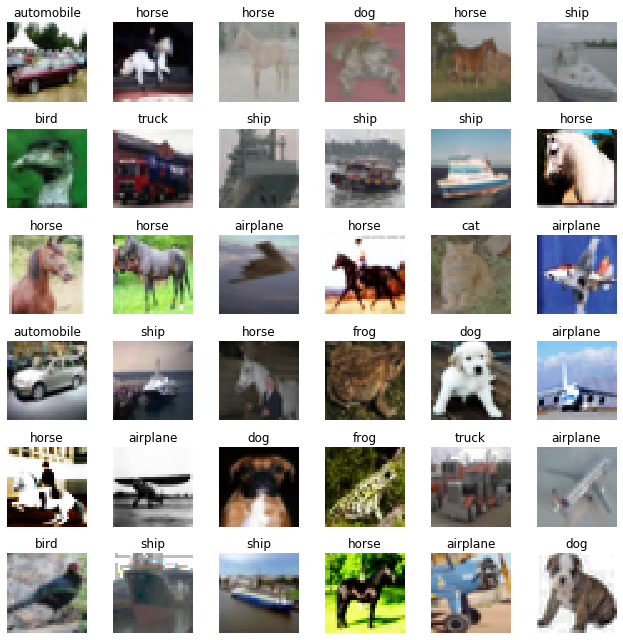

In [56]:
show_image_batch(data.train_dl, train_ds.classes, 6)

## Affine transformation

In [57]:
#export
def grid_sample_nearest(input:TensorImage, coords:FlowField, padding_mode:str='zeros')->TensorImage:
    "Grab pixels in `coords` from `input`. sample with nearest neighbor mode, pad with zeros by default"
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [58]:
#export
def grid_sample(x:TensorImage, coords:FlowField, mode:str='bilinear', padding_mode:str='reflect')->TensorImage:
    "Grab pixels in `coords` from `input` sampling by `mode`. pad is reflect or zeros."
    if padding_mode=='reflect': padding_mode='reflection'
    #if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(size:TensorImageSize)->FlowField:
    size = ((1,)+size)
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

def affine_mult(c:FlowField, m:AffineMatrix)->FlowField:
    if m is None: return c
    size = c.size()
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t()) 
    return c.view(size)

In [59]:
def rotate(degrees):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

In [60]:
def xi(): return train_ds[1][0]
x = xi().data

In [61]:
c=affine_grid(x.shape)

In [62]:
m= rotate(30)
m=x.new_tensor(m)
m

tensor([[ 0.8660, -0.5000,  0.0000],
        [ 0.5000,  0.8660,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])

In [63]:
c[0,...,1]

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9355, -0.9355, -0.9355,  ..., -0.9355, -0.9355, -0.9355],
        [-0.8710, -0.8710, -0.8710,  ..., -0.8710, -0.8710, -0.8710],
        ...,
        [ 0.8710,  0.8710,  0.8710,  ...,  0.8710,  0.8710,  0.8710],
        [ 0.9355,  0.9355,  0.9355,  ...,  0.9355,  0.9355,  0.9355],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])

In [64]:
c[0,...,0]

tensor([[-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        ...,
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000]])

In [65]:
m

tensor([[ 0.8660, -0.5000,  0.0000],
        [ 0.5000,  0.8660,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])

In [66]:
c=affine_mult(c,m);c

tensor([[[[-0.3660, -1.3660],
          [-0.3102, -1.3338],
          [-0.2543, -1.3015],
          ...,
          [ 1.2543, -0.4305],
          [ 1.3102, -0.3983],
          [ 1.3660, -0.3660]],

         [[-0.3983, -1.3102],
          [-0.3424, -1.2779],
          [-0.2865, -1.2456],
          ...,
          [ 1.2220, -0.3747],
          [ 1.2779, -0.3424],
          [ 1.3338, -0.3102]],

         [[-0.4305, -1.2543],
          [-0.3747, -1.2220],
          [-0.3188, -1.1898],
          ...,
          [ 1.1898, -0.3188],
          [ 1.2456, -0.2865],
          [ 1.3015, -0.2543]],

         ...,

         [[-1.3015,  0.2543],
          [-1.2456,  0.2865],
          [-1.1898,  0.3188],
          ...,
          [ 0.3188,  1.1898],
          [ 0.3747,  1.2220],
          [ 0.4305,  1.2543]],

         [[-1.3338,  0.3102],
          [-1.2779,  0.3424],
          [-1.2220,  0.3747],
          ...,
          [ 0.2865,  1.2456],
          [ 0.3424,  1.2779],
          [ 0.3983,  1.3102]],



In [67]:
c[0,...,0]

tensor([[-0.3660, -0.3102, -0.2543,  ...,  1.2543,  1.3102,  1.3660],
        [-0.3983, -0.3424, -0.2865,  ...,  1.2220,  1.2779,  1.3338],
        [-0.4305, -0.3747, -0.3188,  ...,  1.1898,  1.2456,  1.3015],
        ...,
        [-1.3015, -1.2456, -1.1898,  ...,  0.3188,  0.3747,  0.4305],
        [-1.3338, -1.2779, -1.2220,  ...,  0.2865,  0.3424,  0.3983],
        [-1.3660, -1.3102, -1.2543,  ...,  0.2543,  0.3102,  0.3660]])

In [68]:
c[0,...,1]

tensor([[-1.3660, -1.3338, -1.3015,  ..., -0.4305, -0.3983, -0.3660],
        [-1.3102, -1.2779, -1.2456,  ..., -0.3747, -0.3424, -0.3102],
        [-1.2543, -1.2220, -1.1898,  ..., -0.3188, -0.2865, -0.2543],
        ...,
        [ 0.2543,  0.2865,  0.3188,  ...,  1.1898,  1.2220,  1.2543],
        [ 0.3102,  0.3424,  0.3747,  ...,  1.2456,  1.2779,  1.3102],
        [ 0.3660,  0.3983,  0.4305,  ...,  1.3015,  1.3338,  1.3660]])

D:\narain\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


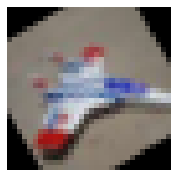

In [69]:
img2=grid_sample(x, c, padding_mode='zeros')
show_image(img2)

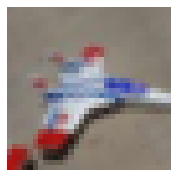

In [70]:
xi().affine(rotate, 30).show()

In [71]:
#export
class TfmAffine(Transform): 
    "Wraps affine tfm funcs"
    order,_wrap = 5,'affine'
class TfmPixel(Transform): 
    "Wraps pixel tfm funcs"
    order,_wrap = 10,'pixel'

@TfmAffine
def rotate(degrees:uniform):
    "Affine func that rotates the image"
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

def get_zoom_mat(sw:float, sh:float, c:float, r:float)->AffineMatrix:
    "`sw`,`sh` scale width,height - `c`,`r` focus col,row"
    return [[sw, 0,  c],
            [0, sh,  r],
            [0,  0, 1.]]

@TfmAffine
def zoom(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5):
    "Zoom image by `scale`. `row_pct`,`col_pct` select focal point of zoom"
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return get_zoom_mat(1/scale, 1/scale, col_c, row_c)

@TfmAffine
def squish(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5):
    "Squish image by `scale`. `row_pct`,`col_pct` select focal point of zoom"
    if scale <= 1: 
        col_c = (1-scale) * (2*col_pct - 1)
        return get_zoom_mat(scale, 1, col_c, 0.)
    else:          
        row_c = (1-1/scale) * (2*row_pct - 1)
        return get_zoom_mat(1, 1/scale, 0., row_c)

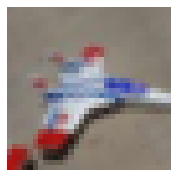

In [72]:
rotate(xi(), 30).show()

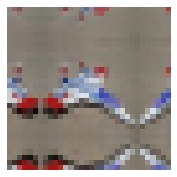

In [73]:
zoom(xi(), 0.6).show()

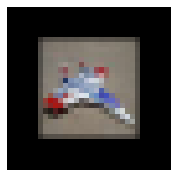

In [74]:
zoom(xi(), 0.6).set_sample(padding_mode='zeros').show()

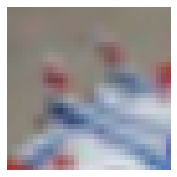

In [75]:
zoom(xi(), 2, 0.2,0.2).show()

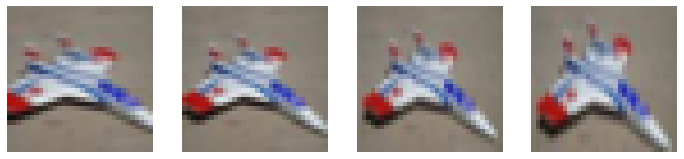

In [76]:
scales=[0.75, 0.9, 1.1, 1.33]

_, axes= plt.subplots(1,4, figsize=(12,3))
for i,ax in enumerate(axes): squish(xi(), scales[i]).show(ax)

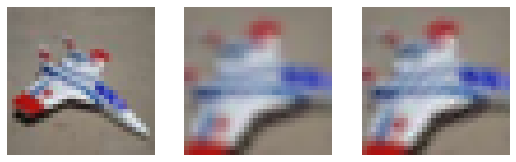

In [77]:
img2= rotate(xi(), 30).refresh()
img2=zoom(img2, 1.6)
_, axes=plt.subplots(1,3, figsize=(9,3))
xi().show(axes[0])
img2.show(axes[1])
zoom(rotate(xi(), 30), 1.6).show(axes[2])

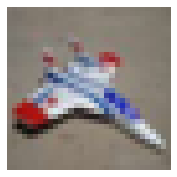

In [78]:
xi().show()

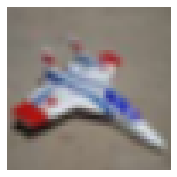

In [79]:
xi().resize(48).show()

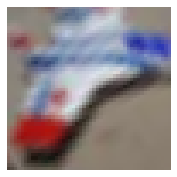

In [80]:
img2=zoom(xi().resize(48), 1.6, 0.8, 0.2)
rotate(img2, 30).show()

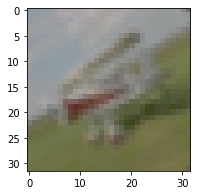

In [81]:
img2=zoom(xi().resize(24), 1.6, 0.8,0.2)
rotate(img,30).show(hide_axis=False)

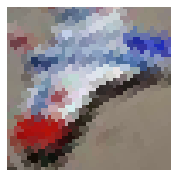

In [82]:
img2= zoom(xi().resize(48), 1.6, 0.8, 0.2)
rotate(img2, 30).set_sample(mode='nearest').show()

## random affine

In [85]:
tfm = rotate(degrees=(-45,45.), p=0.75); tfm

RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45, 45.0)}, p=0.75, resolved={}, do_run=True, is_random=True)

In [86]:
tfm.resolve(); tfm

RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45, 45.0)}, p=0.75, resolved={'degrees': -33.01391229805816}, do_run=True, is_random=True)

In [87]:
#export
def apply_tfms(tfms:TfmList, x:TensorImage, do_resolve:bool=True, 
               xtra:Optional[Dict[Transform,dict]]=None, size:TensorImageSize=None, **kwargs:Any)->TensorImage:
    "Apply `tfms` to x, resize to `size`. `do_resolve` rebind random params. `xtra` custom args for a tfm"
    if not (tfms or size): return x
    if not xtra: xtra={}
    tfms = sorted(listify(tfms), key=lambda o: o.tfm.order)
    if do_resolve: resolve_tfms(tfms)
    x = x.clone()
    if kwargs: x.set_sample(**kwargs)
    if size: x.resize(size)
    for tfm in tfms:
        if tfm.tfm in xtra: x = tfm(x, **xtra[tfm.tfm])
        else:               x = tfm(x)
    return x

AttributeError: 'Tensor' object has no attribute 'show'

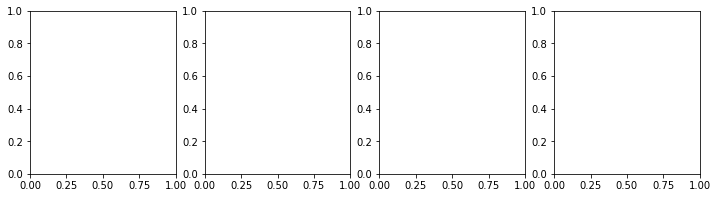

In [88]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfm, x).show(ax)

AttributeError: 'Tensor' object has no attribute 'affine'

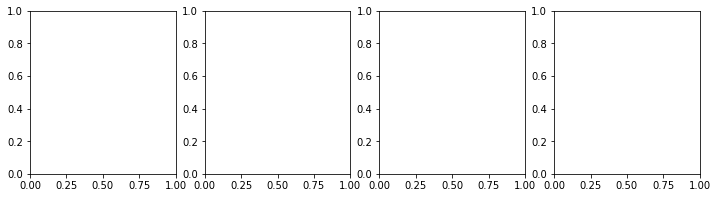

In [89]:
tfms = [rotate(degrees=(-45,45.), p=0.75),
        zoom(scale=(0.5,2.0), p=0.75)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x).show(ax)

AttributeError: 'Tensor' object has no attribute 'set_sample'

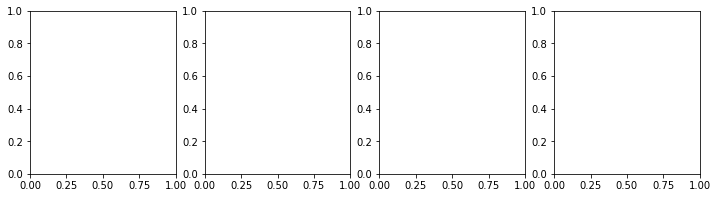

In [90]:
tfms = [rotate(degrees=(-45,45.), p=0.75),
        zoom(scale=(1.0,2.0), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x, padding_mode='zeros', size=64).show(ax)

AttributeError: 'Tensor' object has no attribute 'affine'

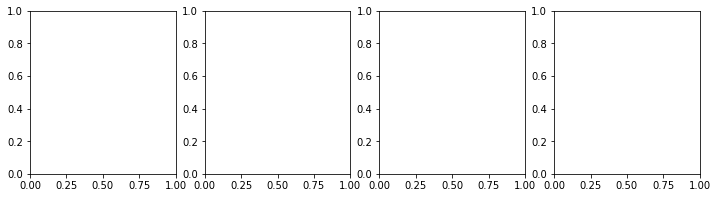

In [91]:
tfms = [squish(scale=(0.5,2), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x).show(ax)

## coord and pixel

In [92]:
#export
class TfmCoord(Transform): order,_wrap = 4,'coord'

@TfmCoord
def jitter(c, size, magnitude:uniform):
    return c.add_((torch.rand_like(c)-0.5)*magnitude*2)

@TfmPixel
def flip_lr(x): return x.flip(2)

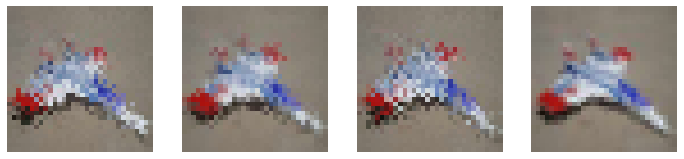

In [93]:
tfm = jitter(magnitude=(0,0.1))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    tfm(xi()).show(ax)

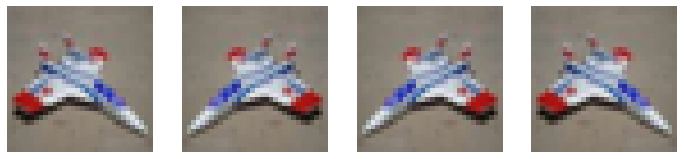

In [94]:
tfm = flip_lr(p=0.5)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    tfm(xi()).show(ax)

## crop and pad

In [95]:
[(o.__name__,o.order) for o in
    sorted((Transform,TfmAffine,TfmCoord,TfmLighting,TfmPixel),key=attrgetter('order'))]

[('Transform', 0),
 ('TfmCoord', 4),
 ('TfmAffine', 5),
 ('TfmLighting', 8),
 ('TfmPixel', 10)]

In [96]:
#export
@partial(TfmPixel, order=-10)
def pad(x, padding, mode='reflect'):
    "Pad `x` with `padding` pixels. `mode` fills in space ('reflect','zeros',etc)"
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@TfmPixel
def crop(x, size, row_pct:uniform=0.5, col_pct:uniform=0.5):
    "Crop `x` to `size` pixels. `row_pct`,`col_pct` select focal point of crop"
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1) * row_pct)
    col = int((x.size(2)-cols+1) * col_pct)
    return x[:, row:row+rows, col:col+cols].contiguous()

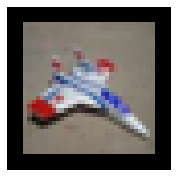

In [97]:
pad(xi(), 4, 'constant').show()

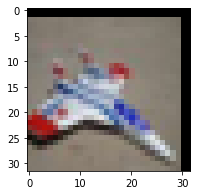

In [98]:
crop(pad(xi(), 4, 'constant'), 32, 0.25, 0.75).show(hide_axis=False)

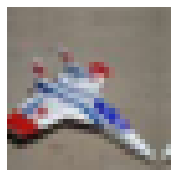

In [99]:
crop(pad(xi(), 4), 32, 0.25, 0.75).show()

In [100]:
tfms = [flip_lr(p=0.5),
        pad(padding=4, mode='constant'),
        crop(size=32, row_pct=(0,1.), col_pct=(0,1.))]

AttributeError: 'Tensor' object has no attribute 'pixel'

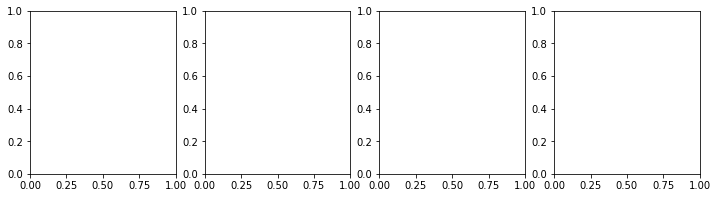

In [101]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms, x).show(ax)

In [102]:
tfms = [
    flip_lr(p=0.5),
    contrast(scale=(0.5,2.0)),
    brightness(change=(0.3,0.7)),
    rotate(degrees=(-45,45.), p=0.5),
    zoom(scale=(0.5,1.2), p=0.8)
]

AttributeError: 'Tensor' object has no attribute 'affine'

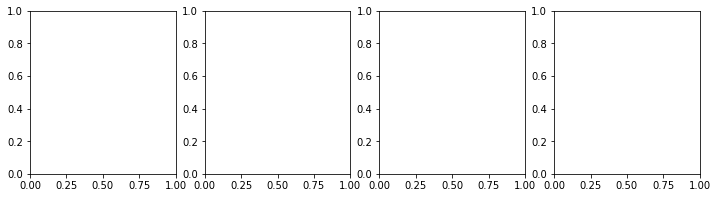

In [103]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms, x).show(ax)

AttributeError: 'Tensor' object has no attribute 'set_sample'

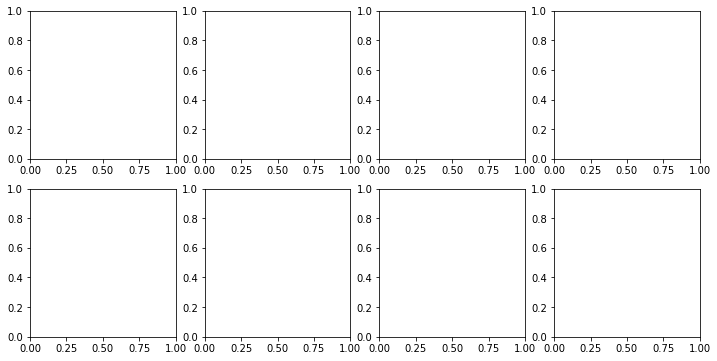

In [104]:
_,axes = plt.subplots(2,4, figsize=(12,6))

for i in range(4):
    apply_tfms(tfms, x, padding_mode='zeros', size=48).show(axes[0][i], hide_axis=False)
    apply_tfms(tfms, x, mode='nearest', do_resolve=False).show(axes[1][i], hide_axis=False)

In [106]:
#export
def compute_zs_mat(sz:TensorImageSize, scale:float, squish:float, 
                   invert:bool, row_pct:float, col_pct:float)->AffineMatrix:
    "Utility routine to compute zoom/squish matrix"
    orig_ratio = math.sqrt(sz[2]/sz[1])
    for s,r,i in zip(scale,squish, invert):
        s,r = math.sqrt(s),math.sqrt(r)
        if s * r <= 1 and s / r <= 1: #Test if we are completely inside the picture
            w,h = (s/r, s*r) if i else (s*r,s/r)
            w /= orig_ratio
            h *= orig_ratio
            col_c = (1-w) * (2*col_pct - 1)
            row_c = (1-h) * (2*row_pct - 1)
            return get_zoom_mat(w, h, col_c, row_c)
        
    #Fallback, hack to emulate a center crop without cropping anything yet.
    if orig_ratio > 1: return get_zoom_mat(1/orig_ratio**2, 1, 0, 0.)
    else:              return get_zoom_mat(1, orig_ratio**2, 0, 0.)

@TfmCoord
def zoom_squish(c, size, scale:uniform=1.0, squish:uniform=1.0, invert:rand_bool=False, 
                row_pct:uniform=0.5, col_pct:uniform=0.5):
    #This is intended for scale, squish and invert to be of size 10 (or whatever) so that the transform
    #can try a few zoom/squishes before falling back to center crop (like torchvision.RandomResizedCrop)
    m = compute_zs_mat(size, scale, squish, invert, row_pct, col_pct)
    return affine_mult(c, FloatTensor(m))

In [107]:
rrc = zoom_squish(scale=(0.25,1.0,10), squish=(0.5,1.0,10), invert=(0.5,10),
                                  row_pct=(0,1.), col_pct=(0,1.))

D:\narain\anaconda3\envs\torch\lib\site-packages\torch\tensor.py:330: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


RuntimeError: requested resize to 32 (32 elements in total), but the given tensor has a size of 3x32x32 (3072 elements). autograd's resize can only change the shape of a given tensor, while preserving the number of elements. 

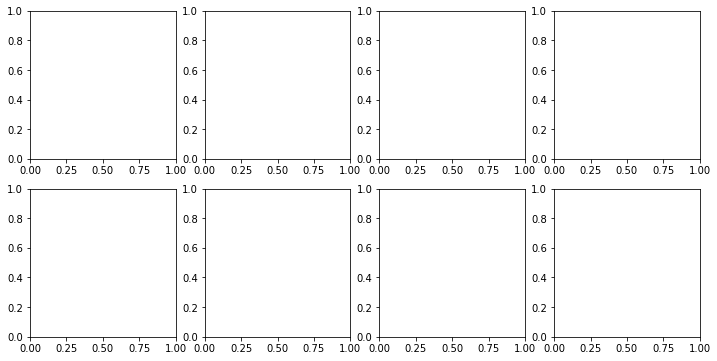

In [108]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    apply_tfms(rrc, x, size=32).show(axes[0][i])
    apply_tfms(rrc, x, do_resolve=False, mode='nearest').show(axes[1][i])